> "Don't pray for an easy life. Pray for the strength to endure the hard one."
>
> Bruce Lee

# Preamble

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import torch

In [3]:
torch.__version__

'2.3.1+cu121'

# Torch

https://pytorch.org/

# Standard layers

* [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): $y = x A^T + b$

* Automatically, set ```requires_grad``` true.

In [4]:
lay = torch.nn.Linear(2, 3) # from 2 units to 3 units

In [5]:
lay._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[-0.4735, -0.1099],
                      [ 0.6742, -0.2763],
                      [ 0.5294,  0.0614]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([-0.3354, -0.3428, -0.3661], requires_grad=True))])

In [6]:
# N, D
x = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float()

In [7]:
lay.forward(x)

tensor([[-0.3354, -0.3428, -0.3661],
        [-0.4453, -0.6190, -0.3047],
        [-0.8089,  0.3314,  0.1633],
        [-0.9188,  0.0551,  0.2247]], grad_fn=<AddmmBackward0>)

In [8]:
lay(x)

tensor([[-0.3354, -0.3428, -0.3661],
        [-0.4453, -0.6190, -0.3047],
        [-0.8089,  0.3314,  0.1633],
        [-0.9188,  0.0551,  0.2247]], grad_fn=<AddmmBackward0>)

## Exercise: MLP with standard layers

In [9]:
fc = torch.nn.Linear(2, 3)

# N,2
x = torch.tensor([[1, -1]]).float()

fc(x)

tensor([[ 0.4782, -0.0886, -0.3205]], grad_fn=<AddmmBackward0>)

In [10]:
fc._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[-0.6321, -0.6694],
                      [-0.6034, -0.6508],
                      [-0.4476, -0.3903]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([ 0.4409, -0.1360, -0.2632], requires_grad=True))])

In [11]:
fc._parameters['weight']

Parameter containing:
tensor([[-0.6321, -0.6694],
        [-0.6034, -0.6508],
        [-0.4476, -0.3903]], requires_grad=True)

In [12]:
y = torch.sum(fc(x))
y

tensor(0.0691, grad_fn=<SumBackward0>)

In [13]:
y.backward()

In [14]:
fc._parameters.keys()

odict_keys(['weight', 'bias'])

In [15]:
fc._parameters['weight'].grad

tensor([[ 1., -1.],
        [ 1., -1.],
        [ 1., -1.]])

In [16]:
fc._parameters['weight'].grad.is_sparse

False

In [17]:
fc._parameters['weight']

Parameter containing:
tensor([[-0.6321, -0.6694],
        [-0.6034, -0.6508],
        [-0.4476, -0.3903]], requires_grad=True)

In [18]:
fc._parameters['weight'].grad

tensor([[ 1., -1.],
        [ 1., -1.],
        [ 1., -1.]])

In [19]:
## adapted from https://github.com/pytorch/pytorch/blob/v2.6.0/torch/optim/sgd.py#L353
lr = -0.01
with torch.no_grad():
    fc._parameters['weight'].add_(fc._parameters['weight'].grad, alpha=-lr)

In [20]:
fc._parameters['weight']

Parameter containing:
tensor([[-0.6221, -0.6794],
        [-0.5934, -0.6608],
        [-0.4376, -0.4003]], requires_grad=True)

In [21]:
fc._parameters['weight'].grad

tensor([[ 1., -1.],
        [ 1., -1.],
        [ 1., -1.]])

In [22]:
fc._parameters['weight'].grad.zero_()

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [23]:
fc._parameters['weight'].grad

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [24]:
lr = -0.01
with torch.no_grad():
    fc._parameters['weight'] -= fc._parameters['weight'].grad * lr

### mlp_v1

In [25]:
class mlp_v1:
    def __init__(self, params=None):
        self.losses = []
        self.fc1 = torch.nn.Linear(2, 3)
        self.h1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(3, 3)
        self.h2 = torch.nn.Sigmoid() 
        self.losses = []

    def predict(self, x):
        '''
        x: (N,D)
        '''
        a1 = self.fc1(x)
        z1 = self.h1(a1)
        a2 = self.fc2(z1)
        z2 = self.h2(a2)
        
        return z2

    def fit(self, X, Y, lr, nepochs):
        losses = self.losses
        for j in range(nepochs):
            # Forward pass
            a1 = self.fc1(X)
            z1 = self.h1(a1)
            a2 = self.fc2(z1)
            z2 = self.h2(a2)
            
            Yp = z2
            
            # Calculate loss
            # lossf = torch.nn.MSELoss()
            lossf = torch.nn.BCELoss()            
            loss = lossf(Yp, Y)
            
            # Calculate gradient with autograd
            loss.backward()

            # Update params
            with torch.no_grad():
                self.fc1._parameters['weight'] -= lr*self.fc1._parameters['weight'].grad
                self.fc1._parameters['bias']   -= lr*self.fc1._parameters['bias'].grad
                self.fc2._parameters['weight'] -= lr*self.fc2._parameters['weight'].grad
                self.fc2._parameters['bias']   -= lr*self.fc2._parameters['bias'].grad

                self.fc1._parameters['weight'].grad.zero_()
                self.fc1._parameters['bias'].grad.zero_()
                self.fc2._parameters['weight'].grad.zero_()
                self.fc2._parameters['bias'].grad.zero_()                
            # end with
            
            # Track losses
            losses.append(loss.item())
        # end for i
        return losses

In [26]:
# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float()

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float()

net = mlp_v1()

Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

tensor([[0.5080, 0.6164, 0.4800],
        [0.4890, 0.5064, 0.4306],
        [0.5339, 0.6708, 0.4888],
        [0.5139, 0.5659, 0.4375]], grad_fn=<SigmoidBackward0>)
mse= 0.24553818


In [27]:
net.fc1._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[ 0.1792, -0.6322],
                      [ 0.1032,  0.0372],
                      [-0.2780,  0.2151]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([ 0.6280, -0.1000,  0.5710], requires_grad=True))])

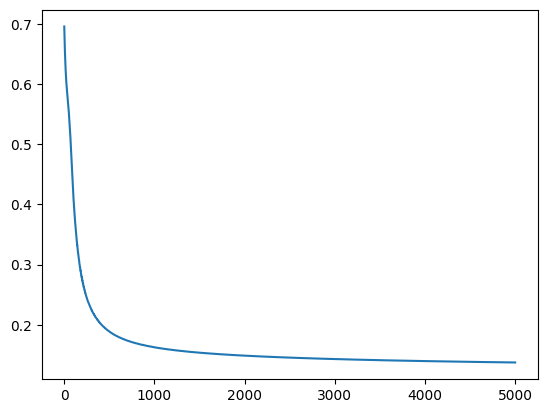

In [28]:
# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float()

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float()

net = mlp_v1()
losses = net.fit(X, Y, 0.4, 5000)
plt.plot(losses)

In [29]:
Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[1.0509e-03, 2.3050e-02, 5.0699e-01],
        [4.1891e-03, 9.8049e-01, 4.3578e-01],
        [9.7314e-04, 1.0000e+00, 9.9958e-01],
        [9.9891e-01, 1.0000e+00, 5.7505e-02]], grad_fn=<SigmoidBackward0>)
mse= 0.048302155
tensor([[False, False,  True],
        [False,  True, False],
        [False,  True,  True],
        [ True,  True, False]])


# Optimizer

> [torch.optim.sgd](https://github.com/pytorch/pytorch/blob/v2.6.0/torch/optim/sgd.py#L26) > ... > [```_single_tensor_sgd```](https://github.com/pytorch/pytorch/blob/v2.6.0/torch/optim/sgd.py#L246)

$\min_u (u-3)^2$

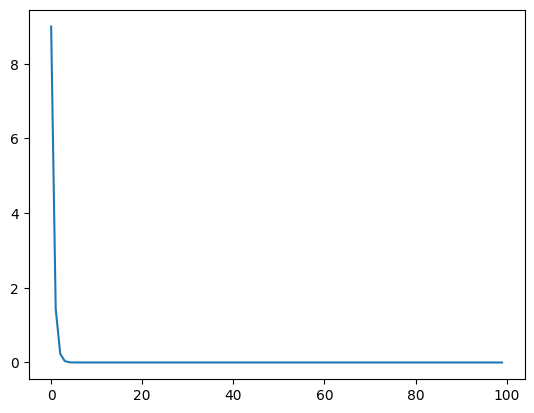

In [30]:
lossf = lambda u: (u - 3)**2
lr = 0.3
nepochs = 100

losses = []

u = torch.tensor([0.0], requires_grad=True)
param = [u]

opt = torch.optim.SGD(param, lr)
# opt = torch.optim.Adam(u, lr)

for i in range(nepochs):
    u = param[0]
    loss = lossf(u)
    loss.backward()

    # Update u
    opt.step()  # c.f. u -= lr*u.grad or u = update(u)
    u.grad.zero_()
    losses.append(loss.item())
# end for i

plt.plot(losses)

In [31]:
param

[tensor([3.], requires_grad=True)]

## Adam

[tensor([3.0000], requires_grad=True)]


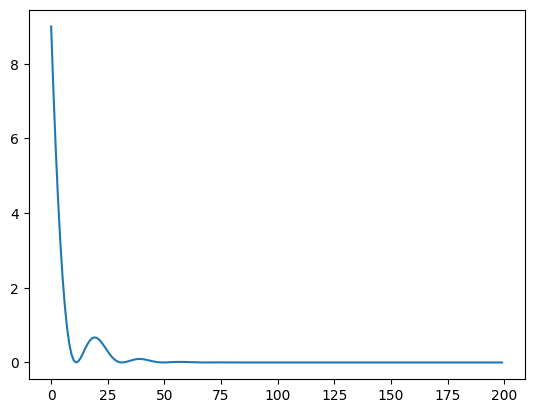

In [32]:
lossf = lambda u: (u - 3)**2
lr = 0.3
nepochs = 200

losses = []

u = torch.tensor([0.0], requires_grad=True)
param = [u]

# opt = torch.optim.SGD(param, lr)
opt = torch.optim.Adam(param, lr)

for i in range(nepochs):
    u = param[0]
    loss = lossf(u)
    loss.backward()

    # Update u
    opt.step()  # c.f. u -= lr*u.grad or u = update(u)
    u.grad.zero_()
    losses.append(loss.item())
# end for i

plt.plot(losses)
print(param)

Adam is designed for multi-dimensional variables.

## Put optimizer in trainer

1. Have the class inherited from ```torch.nn.Module``` for easy access to method ```parameters()```.

   Don't forget to have ```super(<class>, self).__init__()``` called in the ```__init__``` for properly setting up all the inherited attributes and methods.

2. Set up optimizer.

3. Update parameters with method ```step()``` of the optimizer. The ```torch.no_grad()``` session is NOT necessary.

4. Clear gradients.

### mlp_v2

In [51]:
class mlp_v2(torch.nn.Module):                   ## <- Inherited from torch.nn.Module
    def __init__(self, params=None):
        super(mlp_v2, self).__init__()           ## <- Call super(..).__init__()
        
        self.fc1 = torch.nn.Linear(2, 4)
        self.h1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(4, 3)
        self.h2 = torch.nn.Sigmoid() 
        self.losses = []

    def predict(self, x):
        '''
        x: (N,D)
        '''
        a1 = self.fc1(x)
        z1 = self.h1(a1)
        a2 = self.fc2(z1)
        z2 = self.h2(a2)
        
        return z2

    def fit(self, X, Y, lr, nepochs):
        # opt = torch.optim.Adam(self.parameters(), lr)  ## <- Set up optimizer
        opt = torch.optim.SGD(self.parameters(), lr)  ## <- Set up optimizer
        
        losses = self.losses
        for j in range(nepochs):
            # Forward pass
            a1 = self.fc1(X)
            z1 = self.h1(a1)
            a2 = self.fc2(z1)
            z2 = self.h2(a2)
            
            Yp = z2
            
            # Calculate loss
            # lossf = torch.nn.MSELoss()
            lossf = torch.nn.BCELoss()            
            loss = lossf(Yp, Y)
            
            # Calculate gradient with autograd
            loss.backward()

            # Update params
            opt.step()                         ## <- Update one step
            
            self.zero_grad()                   ## <- Clear gradient
            
            # Track losses
            losses.append(loss.item())
        # end for i
        return losses

In [52]:
# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float()

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float()

net = mlp_v2()

Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

tensor([[0.3700, 0.5641, 0.4410],
        [0.3836, 0.5712, 0.4254],
        [0.3293, 0.4990, 0.4777],
        [0.3309, 0.5016, 0.4763]], grad_fn=<SigmoidBackward0>)
mse= 0.2388284


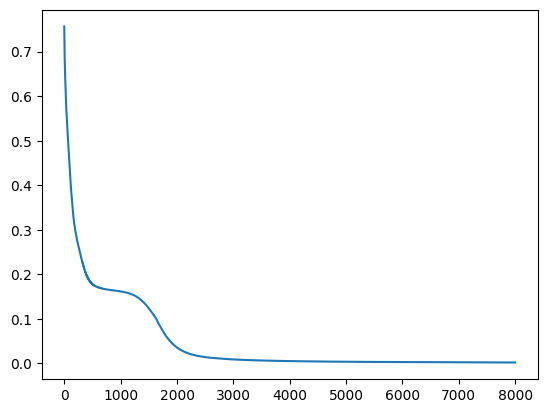

In [53]:
# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float()

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float()

net = mlp_v2()
losses = net.fit(X, Y, 0.3, 8000)
plt.plot(losses)

In [54]:
Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[9.9638e-04, 5.0965e-03, 8.5692e-03],
        [3.2828e-04, 9.9974e-01, 9.9939e-01],
        [1.2591e-05, 9.9940e-01, 9.9752e-01],
        [9.9987e-01, 1.0000e+00, 2.0201e-03]], grad_fn=<SigmoidBackward0>)
mse= 9.294857e-06
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


### Variation 2

In [55]:
class mlp_v2(torch.nn.Module):                   ## <- Inherited from torch.nn.Module
    def __init__(self, params=None):
        super(mlp_v2, self).__init__()           ## <- Call super(..).__init__()
        
        self.fc1 = torch.nn.Linear(2, 4)
        self.h1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(4, 3)
        self.h2 = torch.nn.Sigmoid() 
        self.losses = []

    def predict(self, x):
        '''
        x: (N,D)
        '''
        a1 = self.fc1(x)
        z1 = self.h1(a1)
        a2 = self.fc2(z1)
        z2 = self.h2(a2)
        
        return z2

    def fit(self, X, Y, lr, nepochs):
        opt = torch.optim.Adam(self.parameters(), lr)  ## <- Set up optimizer
        
        losses = self.losses
        for j in range(nepochs):
            # Forward pass
            a1 = self.fc1(X)
            z1 = self.h1(a1)
            a2 = self.fc2(z1)
            z2 = self.h2(a2)
            
            Yp = z2
            
            # Calculate loss
            # lossf = torch.nn.MSELoss()
            lossf = torch.nn.BCELoss()            
            loss = lossf(Yp, Y)
            
            # Calculate gradient with autograd
            loss.backward()

            # Update params
            opt.step()                         ## <- Update one step
            
            opt.zero_grad()                    ## <- Clear gradient
            
            # Track losses
            losses.append(loss.item())
        # end for i
        return losses

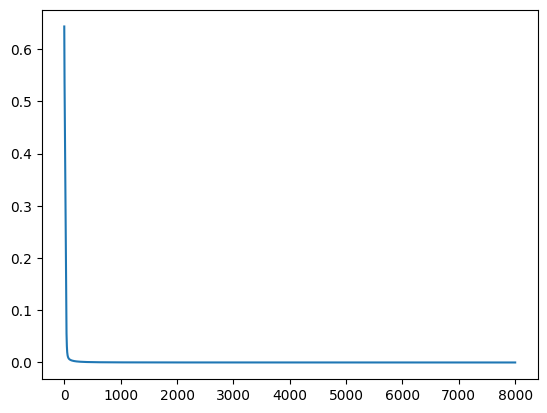

In [56]:
# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float()

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float()

net = mlp_v2()
losses = net.fit(X, Y, 0.1, 8000)
plt.plot(losses)

In [57]:
Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[7.1796e-06, 6.8111e-06, 3.5843e-06],
        [4.2047e-08, 1.0000e+00, 1.0000e+00],
        [4.2058e-08, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.7899e-07]], grad_fn=<SigmoidBackward0>)
mse= 9.244479e-12
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


### Variation 3

In [61]:
class mlp_v2(torch.nn.Module):                   ## <- Inherited from torch.nn.Module
    def __init__(self, params=None):
        super(mlp_v2, self).__init__()           ## <- Call super(..).__init__()
        
        self.fc1 = torch.nn.Linear(2, 4)
        self.h1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(4, 3)
        self.h2 = torch.nn.Sigmoid() 
        self.losses = []

    def predict(self, x):
        '''
        x: (N,D)
        '''
        a1 = self.fc1(x)
        z1 = self.h1(a1)
        a2 = self.fc2(z1)
        z2 = self.h2(a2)
        
        return z2

    def fit(self, X, Y, lr, nepochs):
        opt = torch.optim.Adam(self.parameters(), lr)  ## <- Set up optimizer
        
        losses = self.losses
        for j in range(nepochs):

            opt.zero_grad()                    ## <- Clear gradient
            
            # Forward pass
            a1 = self.fc1(X)
            z1 = self.h1(a1)
            a2 = self.fc2(z1)
            z2 = self.h2(a2)
            
            Yp = z2
            
            # Calculate loss
            # lossf = torch.nn.MSELoss()
            lossf = torch.nn.BCELoss()            
            loss = lossf(Yp, Y)
            
            # Calculate gradient with autograd
            loss.backward()

            # Update params
            opt.step()                         ## <- Update one step
                        
            # Track losses
            losses.append(loss.item())
        # end for i
        return losses

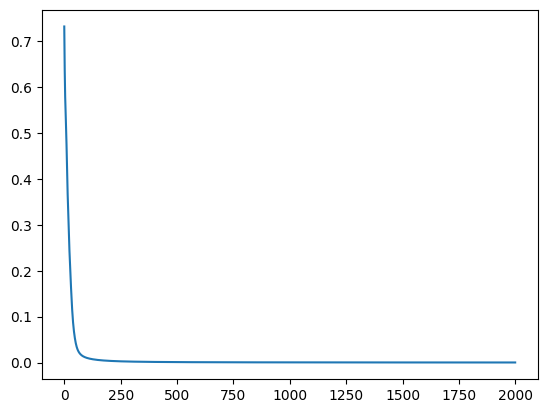

In [62]:
# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float()

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float()

net = mlp_v2()
losses = net.fit(X, Y, 0.1, 2000)
plt.plot(losses)

In [63]:
Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[6.8747e-08, 1.4941e-05, 8.7291e-06],
        [2.1157e-04, 9.9984e-01, 9.9990e-01],
        [2.1134e-04, 9.9984e-01, 9.9990e-01],
        [9.9998e-01, 1.0000e+00, 1.3026e-05]], grad_fn=<SigmoidBackward0>)
mse= 1.3813569e-08
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


### Variation 4: outside trainer

Model is leaner, when we have an external trainer.

In [182]:
class mlp_v3(torch.nn.Module):                   ## <- Inherited from torch.nn.Module
    def __init__(self, params=None):
        super(mlp_v3, self).__init__()           ## <- Call super(..).__init__()
        
        self.fc1 = torch.nn.Linear(2, 5)
        self.h1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(5, 3)
        self.h2 = torch.nn.Sigmoid() 

    def predict(self, x):
        '''
        x: (N,D)
        '''
        a1 = self.fc1(x)
        z1 = self.h1(a1)
        a2 = self.fc2(z1)
        z2 = self.h2(a2)
        
        return z2

    def forward(self, x):
        return self.predict(x)

In [183]:
# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float()

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float()

net = mlp_v3()

In [184]:
net.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('fc1',
               Linear(in_features=2, out_features=5, bias=True)),
              ('h1', ReLU()),
              ('fc2', Linear(in_features=5, out_features=3, bias=True)),
              ('h2', Sigmoid())])}

In [185]:
lr = 0.1
nepochs = 2000
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

net.train()

losses = []
for j in range(nepochs):

    opt.zero_grad()                    ## <- Clear gradient
    
    # Forward pass
    Yp = net(X)    # or net.predict(X)
    
    # Calculate loss
    # lossf = torch.nn.MSELoss()
    lossf = torch.nn.BCELoss()            
    loss = lossf(Yp, Y)
    
    # Calculate gradient with autograd
    loss.backward()

    # Update params
    opt.step()                         ## <- Update one step
                
    # Track losses
    losses.append(loss.item())
# end for i


Text(0, 0.5, 'Loss')

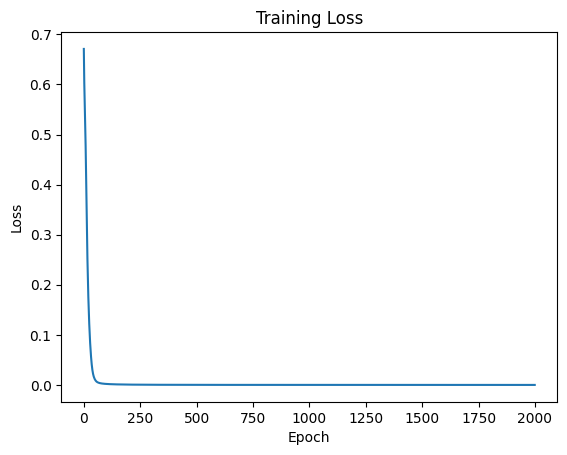

In [186]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [187]:
# net.eval()

Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[4.4385e-16, 5.8484e-06, 1.8399e-05],
        [9.0999e-06, 1.0000e+00, 9.9998e-01],
        [1.0482e-05, 9.9999e-01, 9.9998e-01],
        [9.9999e-01, 1.0000e+00, 1.5500e-05]], grad_fn=<SigmoidBackward0>)
mse= 1.645884e-10
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


# Dataloader

When our dataset is large, we are better off using [```utils.data.DataLoader```](https://pytorch.org/docs/stable/data.html).

1. Write [a dataset class](https://pytorch.org/docs/stable/data.html#map-style-datasets)

   * 1.1. Map-style dataset

       * Make it inherited from ```torch.utils.data.Dataset```
   
       * Call ```super```'s ```__init__()```
      
       * Implement ```__getitem__``` and ```__len__```


   * 1.2. [Iterable-style dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset)

        * Make it inherited from ```IterableDataset```
        
        * Implement ```__iter__```

3. Hook data loader (of class ```torch.utils.data.DataLoader```) with the dataset object.

4. Use the data loader as an iterator.

In [188]:
# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float()

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float()

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, datax, datay):
        self.datax = datax
        self.datay = datay

    def __getitem__(self, index):
        return self.datax[index,:], self.datay[index,:]

    def __len__(self):
        return self.datax.shape[0]

In [189]:
ds = MyDataset(X, Y)

datloader = torch.utils.data.DataLoader(ds)

In [190]:
net = mlp_v3()

lr = 0.1
nepochs = 3000
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# net.train()

losses = []
for j in range(nepochs):
    # print('Epoch', j)
    for xs, ys in datloader:
        # print('*', xs.shape, ys.shape)
        opt.zero_grad()                    ## <- Clear gradient
        
        # Forward pass
        Yp = net(xs)    # or net.predict(X)
        
        # Calculate loss
        # lossf = torch.nn.MSELoss()
        lossf = torch.nn.BCELoss()            
        loss = lossf(Yp, ys)
        
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step
                    
        # Track losses
        losses.append(loss.item())
        
    # end for xs, ys
# end for i


Text(0.5, 1.0, 'Training Loss')

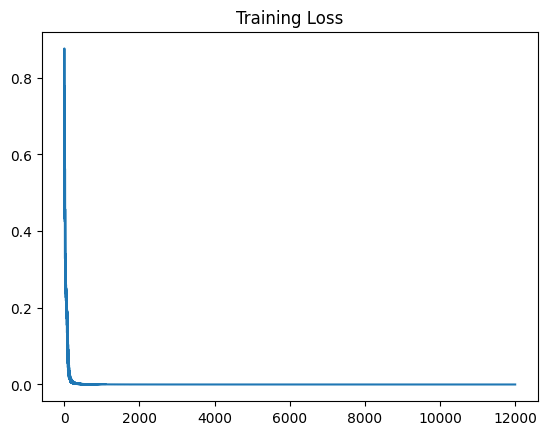

In [191]:
plt.plot(losses)
plt.title('Training Loss')

Q: We set ```nepochs = 2000```. Why do we see 8000?

A: We save for each update, not each epoch!

```
        # Update params
        opt.step()                         ## <- Update one step
                    
        # Track losses
        losses.append(loss.item())
        
    # end for xs, ys
# end for i
```

This is online training or we had batch size = 1.

In [192]:
# net.eval()

Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[9.0856e-25, 1.2415e-08, 1.7170e-07],
        [3.4697e-08, 1.0000e+00, 1.0000e+00],
        [3.5106e-08, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 3.5717e-07]], grad_fn=<SigmoidBackward0>)
mse= 3.461995e-14
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


## Batch size

In [193]:
ds = MyDataset(X, Y)

datloader = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=True)

In [194]:
X.device

device(type='cpu')

In [196]:
net = mlp_v3().to(torch.device(X.device))

lr = 0.1
nepochs = 2000
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# net.train()

losses = []
for j in range(nepochs):
    # print('Epoch', j)
    for xs, ys in datloader:
        # print('*', xs.shape, ys.shape)
        opt.zero_grad()                    ## <- Clear gradient
        
        # Forward pass
        Yp = net(xs)    # or net.predict(X)
        
        # Calculate loss
        # lossf = torch.nn.MSELoss()
        lossf = torch.nn.BCELoss()            
        loss = lossf(Yp, ys)
        
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step
                    
        # Track losses
        losses.append(loss.item())
        
    # end for xs, ys
# end for i

Text(0.5, 1.0, 'Training Loss')

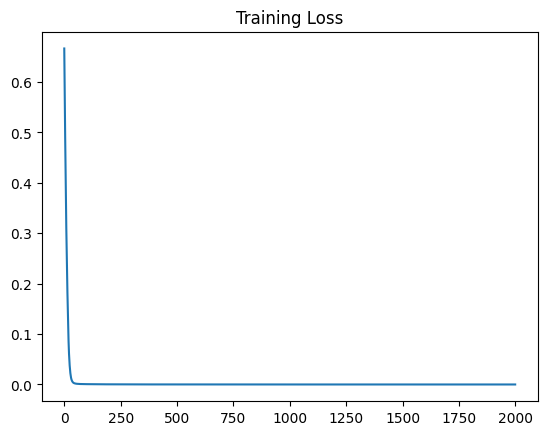

In [197]:
plt.plot(losses)
plt.title('Training Loss')

In [198]:
# net.eval()

Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[6.0816e-15, 4.2777e-06, 9.1893e-06],
        [6.1275e-06, 1.0000e+00, 9.9999e-01],
        [5.3593e-06, 1.0000e+00, 9.9999e-01],
        [9.9999e-01, 1.0000e+00, 1.2482e-05]], grad_fn=<SigmoidBackward0>)
mse= 5.75545e-11
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


## Batch size = 2

In [199]:
ds = MyDataset(X, Y)

datloader = torch.utils.data.DataLoader(ds, batch_size=2, shuffle=True)

In [200]:
net = mlp_v3()

lr = 0.1
nepochs = 2000
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# net.train()

losses = []
for j in range(nepochs):
    # print('Epoch', j)
    for xs, ys in datloader:
        # print('*', xs.shape, ys.shape)
        opt.zero_grad()                    ## <- Clear gradient
        
        # Forward pass
        Yp = net(xs)    # or net.predict(X)
        
        # Calculate loss
        # lossf = torch.nn.MSELoss()
        lossf = torch.nn.BCELoss()            
        loss = lossf(Yp, ys)
        
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step
                    
        # Track losses
        losses.append(loss.item())
        
    # end for xs, ys
# end for i

Text(0.5, 1.0, 'Training Loss')

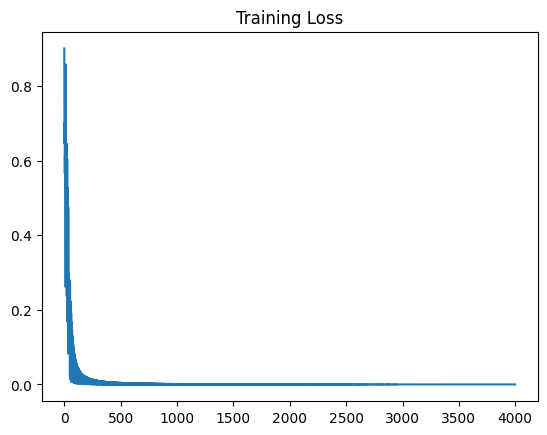

In [201]:
plt.plot(losses)
plt.title('Training Loss')

In [202]:
# net.eval()

Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[3.4188e-06, 9.3984e-06, 4.0544e-06],
        [1.6830e-06, 1.0000e+00, 1.0000e+00],
        [7.0247e-07, 1.0000e+00, 1.0000e+00],
        [9.9982e-01, 9.9978e-01, 1.4032e-04]], grad_fn=<SigmoidBackward0>)
mse= 8.126541e-09
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


# Side trick: Python's yield

In [39]:
def func():
    yield 1
    yield 2
    yield 3

x = func()

for xi in x:
    print(xi)

1
2
3


In [40]:
def func():
    for c in ['a', 'b', 'c', 'd']:
        yield c

x = func()
for xi in x:
    print(xi)

a
b
c
d


In [41]:
def func():
    for c in ['a', 'b', 'c', 'd']:
        yield c

x = func()
for xi in x:
    print(xi)

for xi in x:
    print('*', xi)

x = func()
for xi in x:
    print('>', xi)


a
b
c
d
> a
> b
> c
> d


In [42]:
def func():
    for c in ['a', 'b', 'c', 'd']:
        yield c

for xi in func():
    print(xi)

a
b
c
d


# Side trick: Python's iter

In [43]:
for i in iter([3,4,5]):
    print(i)

3
4
5


In [44]:
x = iter([3,4,5])

print(next(x))
print(next(x))
print(next(x))

3
4
5


In [45]:
next(x)

StopIteration: 

In [46]:
x = iter([3,4,5])
next(x)

3

In [47]:
x = iter([(1,2), (-1,3), (2,4), (-2,5)])

for a, b in x:
    print(a, b)

1 2
-1 3
2 4
-2 5


In [48]:
As = [1, -1, 2, -2]
Bs = [3, 4, 5, 6]

x = iter(zip(As, Bs))

for a, b in x:
    print(a, b)

1 3
-1 4
2 5
-2 6


# Dataloader: iterable dataset

In [203]:
# https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset

class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, datax, datay):
        super(MyIterableDataset).__init__()
        self.datax = datax
        self.datay = datay

    def __iter__(self):
        
        iter_x = self.datax
        iter_y = self.datay
        
        # worker_info = torch.utils.data.get_worker_info()        
        # if worker_info is not None:
        #     # split workload
        #     N, _ = self.datax.shape
        #     per_worker = int(math.ceil( N / float(worker_info.num_workers)))
        #     worker_id = worker_info.id
        #     s = worker_id * per_worker
        #     e = min(s + per_worker, N)

        #     iter_x = self.datax[s:e,:]
        #     iter_y = self.datay[s:e,:]
        # # end if
        return iter(zip(iter_x, iter_y))

In [204]:
# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float()

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float()

ds = MyIterableDataset(X, Y)

In [205]:
for x, y in ds:
    print(x, y)

tensor([0., 0.]) tensor([0., 0., 0.])
tensor([0., 1.]) tensor([0., 1., 1.])
tensor([1., 0.]) tensor([0., 1., 1.])
tensor([1., 1.]) tensor([1., 1., 0.])


In [206]:
list(ds)

[(tensor([0., 0.]), tensor([0., 0., 0.])),
 (tensor([0., 1.]), tensor([0., 1., 1.])),
 (tensor([1., 0.]), tensor([0., 1., 1.])),
 (tensor([1., 1.]), tensor([1., 1., 0.]))]

In [207]:
datloader = torch.utils.data.DataLoader(ds)

In [210]:
net = mlp_v3()

lr = 0.03
nepochs = 5000
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# net.train()

losses = []
for j in range(nepochs):
    # print('Epoch', j)
    for xs, ys in datloader:
        # print('*', xs.shape, ys.shape)
        opt.zero_grad()                    ## <- Clear gradient
        
        # Forward pass
        Yp = net(xs)    # or net.predict(X)
        
        # Calculate loss
        # lossf = torch.nn.MSELoss()
        lossf = torch.nn.BCELoss()            
        loss = lossf(Yp, ys)
        
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step
                    
        # Track losses
        losses.append(loss.item())
        
    # end for xs, ys
# end for i


Text(0.5, 1.0, 'Training Loss')

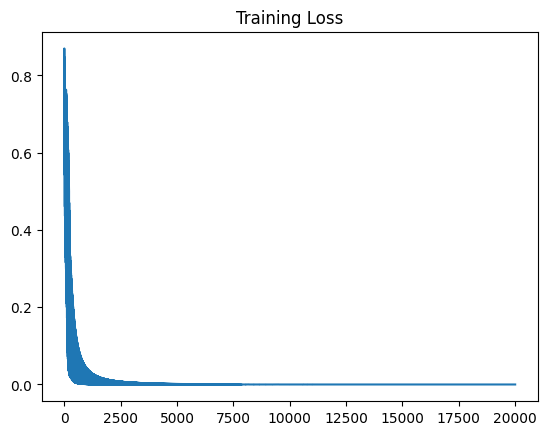

In [211]:
plt.plot(losses)
plt.title('Training Loss')

In [212]:
# net.eval()

Yp = net.predict(X)
print(Yp)

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[6.7921e-09, 1.6643e-08, 6.7980e-09],
        [1.1986e-09, 1.0000e+00, 1.0000e+00],
        [1.0531e-09, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 6.5349e-07]], grad_fn=<SigmoidBackward0>)
mse= 1.12593454e-13
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


# Run it on GPU

In [213]:
class mlp_v4(torch.nn.Module):                   ## <- Inherited from torch.nn.Module
    def __init__(self):
        super(mlp_v4, self).__init__()           ## <- Call super(..).__init__()
        
        self.fc1 = torch.nn.Linear(2, 4)
        self.h1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(4, 3)
        self.h2 = torch.nn.Sigmoid() 

    def predict(self, x):
        '''
        x: (N,D)
        '''
        a1 = self.fc1(x)
        z1 = self.h1(a1)
        a2 = self.fc2(z1)
        z2 = self.h2(a2)
        
        return z2

    def forward(self, x):
        return self.predict(x)

In [214]:
dev = 'cuda'

# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float().to(torch.device(dev))

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float().to(torch.device(dev))

net = mlp_v4().to(torch.device(dev))

In [215]:
lr = 0.1
nepochs = 4000
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# net.train()

losses = []
for j in range(nepochs):

    opt.zero_grad()                    ## <- Clear gradient
    
    # Forward pass
    Yp = net(X)    # or net.predict(X)
    
    # Calculate loss
    # lossf = torch.nn.MSELoss()
    lossf = torch.nn.BCELoss()            
    loss = lossf(Yp, Y)
    
    # Calculate gradient with autograd
    loss.backward()

    # Update params
    opt.step()                         ## <- Update one step
                
    # Track losses
    losses.append(loss.item())
# end for i


Text(0, 0.5, 'Loss')

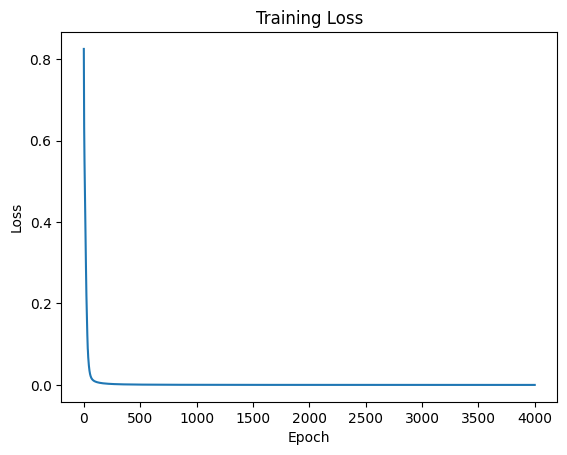

In [216]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [217]:
# net.eval()

Yp = net.predict(X)
print(Yp)

Y = Y.cpu()
Yp = Yp.cpu()

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[6.0909e-07, 3.6857e-06, 6.3736e-07],
        [8.9841e-07, 1.0000e+00, 1.0000e+00],
        [2.0697e-06, 1.0000e+00, 1.0000e+00],
        [9.9991e-01, 9.9992e-01, 3.0267e-05]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
mse= 1.2169287e-09
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


# torch.nn.Sequential

In [218]:
class mlp_v5(torch.nn.Module):                   
    def __init__(self):
        super(mlp_v5, self).__init__()           

        self.model = torch.nn.Sequential(            ## <-- Have all the layers in Sequential, in order
            torch.nn.Linear(2, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 3),
            torch.nn.Sigmoid() 
        )                      
        
    def predict(self, x):
        '''
        x: (N,D)
        '''
        z2 = self.model(x)                          ## <-- No need to go through each layer, manually
        
        return z2

    def forward(self, x):
        return self.predict(x)

In [219]:
dev = 'cuda'

# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float().to(torch.device(dev))

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float().to(torch.device(dev))

net = mlp_v5().to(torch.device(dev))

Text(0, 0.5, 'Loss')

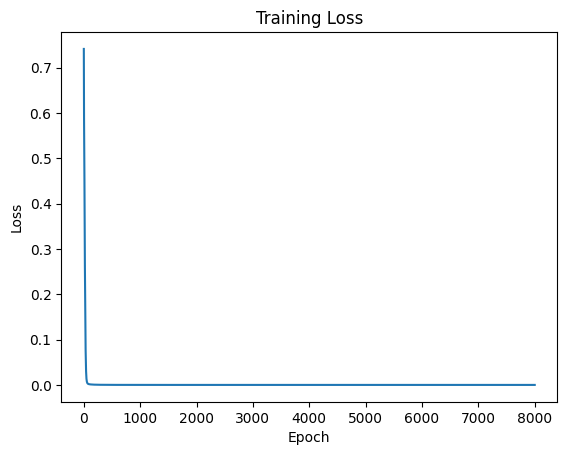

In [220]:
lr = 0.1
nepochs = 8000
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# net.train()

losses = []
for j in range(nepochs):

    opt.zero_grad()                    ## <- Clear gradient
    
    # Forward pass
    Yp = net(X)    # or net.predict(X)
    
    # Calculate loss
    # lossf = torch.nn.MSELoss()
    lossf = torch.nn.BCELoss()            
    loss = lossf(Yp, Y)
    
    # Calculate gradient with autograd
    loss.backward()

    # Update params
    opt.step()                         ## <- Update one step

    # Track losses
    losses.append(loss.item())
# end for i

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [221]:
# net.eval()

Yp = net.predict(X)
print(Yp)

Y = Y.cpu()
Yp = Yp.cpu()

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[5.8704e-13, 2.0661e-07, 3.7855e-07],
        [1.2963e-07, 1.0000e+00, 1.0000e+00],
        [1.1778e-07, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 3.0111e-07]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
mse= 4.8111377e-14
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


## Function compliant with Sequential

https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function

In [222]:
class Exp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i.exp()
        ctx.save_for_backward(result)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        result, = ctx.saved_tensors
        return grad_output * result

input = torch.randn(2,3)

output = Exp.apply(input)
print(output)


tensor([[3.3204, 1.6186, 0.7546],
        [0.6215, 1.9197, 3.4790]])


In [4]:
class f_identity(torch.autograd.Function):
    '''
    f(a) = a
    d f(a)/ d a = 1
    * dz/da * dE/dz = d f(a)/da * dE/dz = 1 dE/dz = dE/dz  
    '''
    @staticmethod
    def forward(ctx, a):
        return a

    @staticmethod
    def backward(ctx, dEz):
        dEa = dEz.clone()
        return dEa

# Version 1 (tested)
class f_relu(torch.autograd.Function):
    '''
    f(a) = (a >= 0)*a
    d f(a)/ d a = (a >= 0)
    * dE/da = dz/da * dE/dz = d f(a)/da * dE/dz = (a >= 0) * dE/dz
    '''
    @staticmethod
    def forward(ctx, a):
        ctx.save_for_backward(a)
        return a.clamp(min=0)

    @staticmethod
    def backward(ctx, dEz):
        a, = ctx.saved_tensors
        dEa = dEz.clone()
        dEa[a<0] = 0
        return dEa


In [5]:
a = torch.randn(2,3)
print('a=', a)
z = f_identity.apply(a)
print('z=', z)

z = f_relu.apply(a)
print('z=', z)

a= tensor([[-0.2977,  0.7294, -2.1098],
        [ 1.7618, -1.7316, -1.2818]])
z= tensor([[-0.2977,  0.7294, -2.1098],
        [ 1.7618, -1.7316, -1.2818]])
z= tensor([[0.0000, 0.7294, 0.0000],
        [1.7618, 0.0000, 0.0000]])


In [8]:
class FRelu(torch.nn.Module):
    def forward(self, x):
        return f_relu.apply(x)

In [9]:
class mlp_v6(torch.nn.Module):                   
    def __init__(self):
        super(mlp_v6, self).__init__()           

        self.model = torch.nn.Sequential(            ## <-- Have all the layers in Sequential, in order
            torch.nn.Linear(2, 4),
            FRelu(),
            torch.nn.Linear(4, 3),
            torch.nn.Sigmoid() 
        )
        
    def predict(self, x):
        '''
        x: (N,D)
        '''
        z2 = self.model(x)                          ## <-- No need to go through each layer, manually
        
        return z2

    def forward(self, x):
        return self.predict(x)

In [10]:
dev = 'cuda'

# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float().to(torch.device(dev))

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float().to(torch.device(dev))

net = mlp_v6().to(torch.device(dev))

Text(0, 0.5, 'Loss')

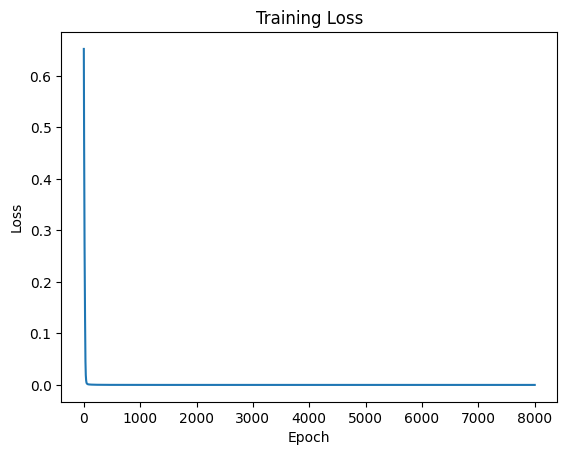

In [11]:
lr = 0.1
nepochs = 8000
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# net.train()

losses = []
for j in range(nepochs):

    opt.zero_grad()                    ## <- Clear gradient
    
    # Forward pass
    Yp = net(X)    # or net.predict(X)
    
    # Calculate loss
    # lossf = torch.nn.MSELoss()
    lossf = torch.nn.BCELoss()            
    loss = lossf(Yp, Y)
    
    # Calculate gradient with autograd
    loss.backward()

    # Update params
    opt.step()                         ## <- Update one step

    # Track losses
    losses.append(loss.item())
# end for i

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [12]:
# net.eval()

Yp = net.predict(X)
print(Yp)

Y = Y.cpu()
Yp = Yp.cpu()

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[3.4021e-11, 1.9756e-07, 9.8785e-08],
        [1.3704e-07, 1.0000e+00, 1.0000e+00],
        [2.3960e-07, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.7020e-07]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
mse= 2.1118556e-14
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


# Save and load a model

In [34]:
!ls .

LearnTorch01v1.ipynb		LearnTorch02v1.ipynb
LearnTorch01v1_toStudent.ipynb	LessonLearned101.ipynb


In [36]:
torch.save(net.state_dict(), './LearnTorch02v1_net.pth')

In [37]:
!ls .

LearnTorch01v1.ipynb		LearnTorch02v1.ipynb	LessonLearned101.ipynb
LearnTorch01v1_toStudent.ipynb	LearnTorch02v1_net.pth


In [38]:
net2 = mlp_v5('cpu') ## Initiate the object of the same class

net2.load_state_dict(torch.load('./LearnTorch02v1_net.pth', map_location='cpu'))

<All keys matched successfully>

In [41]:
# Test loaded model

# net2.eval()

Yp = net2.predict(X.cpu())   ## Recall that we loaded net2 into 'cpu'
print(Yp)

Y = Y.cpu()
Yp = Yp.cpu()

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[5.7346e-05, 7.3892e-05, 3.5000e-05],
        [8.6542e-07, 1.0000e+00, 1.0000e+00],
        [4.8355e-07, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 2.4762e-06]], grad_fn=<SigmoidBackward0>)
mse= 8.331377e-10
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True, False]])


# Initialization

* We can use a default initialization of the layers.

* We also can use one of [the available methods](https://pytorch.org/docs/stable/nn.init.html).

  Recommendations

  * For symmetry activation function, e.g., $\tanh$, try ```xavier_uniform_```
 
  * For asymmetry function, particularly, e.g., ```ReLU```, try ```kaiming_normal_```

* Or, we can do it ourselves.




In [49]:
w = torch.empty(3, 5)
w

tensor([[-1.1882e-33,  4.5696e-41, -1.3368e+20,  3.0649e-41,  4.4842e-44],
        [ 0.0000e+00,  1.5695e-43,  0.0000e+00,  1.5620e+14,  7.0065e-45],
        [-1.3450e+20,  3.0649e-41, -1.8481e+14,  3.0649e-41,  5.0246e+14]])

In [50]:
torch.nn.init.uniform_(w)
w

tensor([[0.8261, 0.7429, 0.0228, 0.6930, 0.9421],
        [0.8631, 0.9183, 0.8165, 0.8113, 0.2996],
        [0.7477, 0.7595, 0.4658, 0.4607, 0.2531]])

In [48]:
lay = torch.nn.Linear(2, 3)

lay.weight.data = torch.zeros(3,2)
lay.weight

Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], requires_grad=True)

In [51]:
torch.nn.init.kaiming_normal_(lay.weight)

lay.weight

Parameter containing:
tensor([[-1.1854,  0.5918],
        [-1.2254, -1.6032],
        [-0.3002,  0.2137]], requires_grad=True)

In [52]:
lay.bias

Parameter containing:
tensor([ 0.6458,  0.0726, -0.3734], requires_grad=True)

In [54]:
lay.bias.size()

torch.Size([3])

In [55]:
lay.bias.data = torch.zeros(3)
lay.bias

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

In [61]:
lays = torch.nn.Sequential(            ## <-- Have all the layers in Sequential, in order
            torch.nn.Linear(2, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 3))

lays

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=3, bias=True)
)

In [63]:
lays[0]

Linear(in_features=2, out_features=3, bias=True)

In [64]:
lays[1]

ReLU()

In [65]:
lays[2]

Linear(in_features=3, out_features=3, bias=True)

In [227]:
class mlp_v6(torch.nn.Module):                   
    def __init__(self, dev='cpu'):
        super(mlp_v6, self).__init__()           

        self.model = torch.nn.Sequential(            ## <-- Have all the layers in Sequential, in order
            torch.nn.Linear(2, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 3),
            torch.nn.Sigmoid() 
        ).to(torch.device(dev))                    

    def init_weights(self):
        torch.nn.init.kaiming_normal_(self.model[0].weight)  # Initialize w
        torch.nn.init.xavier_uniform_(self.model[2].weight)  # Initialize w
        
    def predict(self, x):
        '''
        x: (N,D)
        '''
        z2 = self.model(x)                          ## <-- No need to go through each layer, manually
        
        return z2

    def forward(self, x):
        return self.predict(x)

In [228]:
dev = 'cuda'

# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float().to(torch.device(dev))

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float().to(torch.device(dev))

net = mlp_v6('cuda')

In [229]:
net.model[0].weight

Parameter containing:
tensor([[-0.6777, -0.1233],
        [-0.2717, -0.2874],
        [ 0.2064, -0.2899]], device='cuda:0', requires_grad=True)

In [230]:
net.init_weights()

In [231]:
net.model[0].weight

Parameter containing:
tensor([[-0.3371, -0.0291],
        [ 0.8018, -1.5324],
        [-0.1147, -0.7126]], device='cuda:0', requires_grad=True)

Text(0, 0.5, 'Loss')

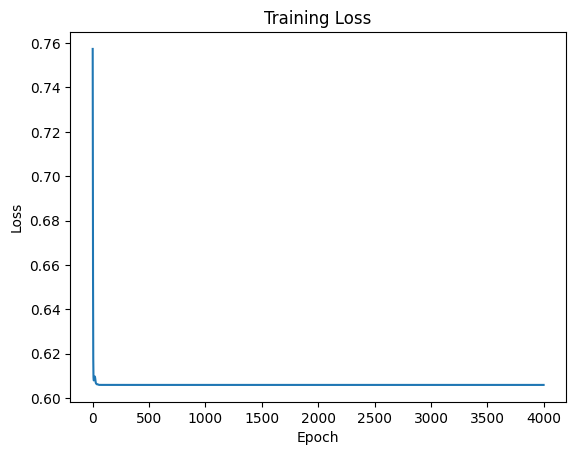

In [232]:
lr = 0.1
nepochs = 4000
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# net.train()

losses = []
for j in range(nepochs):

    opt.zero_grad()                    ## <- Clear gradient
    
    # Forward pass
    Yp = net(X)    # or net.predict(X)
    
    # Calculate loss
    # lossf = torch.nn.MSELoss()
    lossf = torch.nn.BCELoss()            
    loss = lossf(Yp, Y)
    
    # Calculate gradient with autograd
    loss.backward()

    # Update params
    opt.step()                         ## <- Update one step
                
    # Track losses
    losses.append(loss.item())
# end for i

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [233]:
# net.eval()

Yp = net.predict(X)
print(Yp)

Y = Y.cpu()
Yp = Yp.cpu()

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[0.2500, 0.7500, 0.5000],
        [0.2500, 0.7500, 0.5000],
        [0.2500, 0.7500, 0.5000],
        [0.2500, 0.7500, 0.5000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
mse= 0.20833333
tensor([[False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False]])


## Initialization contest

In [83]:
class mlp_v7(torch.nn.Module):                   
    def __init__(self, dev='cpu'):
        super(mlp_v7, self).__init__()           

        self.model = torch.nn.Sequential(            ## <-- Have all the layers in Sequential, in order
            torch.nn.Linear(2, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 3),
            torch.nn.Sigmoid() 
        ).to(torch.device(dev))                    

    def init_weights(self, init_f=torch.nn.init.normal_):
            
        init_f(self.model[0].weight)  # Initialize w
        init_f(self.model[2].weight)  # Initialize w
        
    def predict(self, x):
        '''
        x: (N,D)
        '''
        z2 = self.model(x)                          ## <-- No need to go through each layer, manually
        
        return z2

    def forward(self, x):
        return self.predict(x)

In [90]:
dev = 'cpu'

# N,D
X = torch.tensor([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).float().to(torch.device(dev))

# N,K : and, or, xor
Y = torch.tensor([[0,0,0],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]]).float().to(torch.device(dev))

net = mlp_v7('cpu')

Text(0, 0.5, 'Loss')

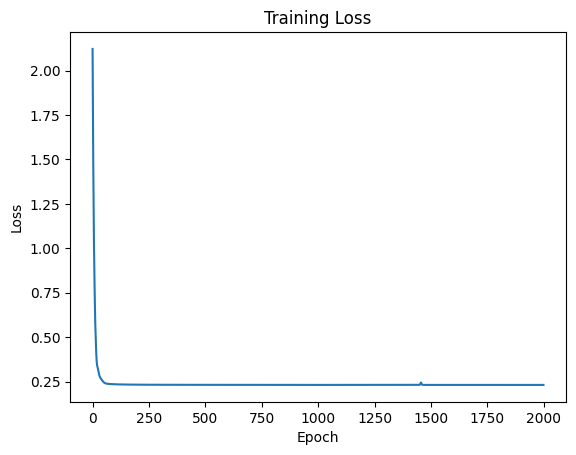

In [92]:
net.init_weights(torch.nn.init.kaiming_normal_) 

lr = 0.1
nepochs = 2000
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# net.train()

losses = []
for j in range(nepochs):

    opt.zero_grad()                    ## <- Clear gradient
    
    # Forward pass
    Yp = net(X)    # or net.predict(X)
    
    # Calculate loss
    # lossf = torch.nn.MSELoss()
    lossf = torch.nn.BCELoss()            
    loss = lossf(Yp, Y)
    
    # Calculate gradient with autograd
    loss.backward()

    # Update params
    opt.step()                         ## <- Update one step
                
    # Track losses
    losses.append(loss.item())
# end for i

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [93]:
# net.eval()

Yp = net.predict(X)
print(Yp)

Y = Y.cpu()
Yp = Yp.cpu()

print('mse=', np.mean( (Yp.detach().numpy() - Y.detach().numpy())**2 ) )

print(Yp > 0.5)

tensor([[1.6211e-05, 7.5575e-05, 1.2612e-05],
        [8.0842e-06, 9.9992e-01, 1.0000e+00],
        [4.9999e-01, 9.9979e-01, 5.0000e-01],
        [4.9999e-01, 9.9979e-01, 5.0000e-01]], grad_fn=<SigmoidBackward0>)
mse= 0.08333334
tensor([[False, False, False],
        [False,  True,  True],
        [False,  True, False],
        [False,  True, False]])


# Experiment and reproducibility

In [98]:
# Adapted from https://github.com/arxyzan/vanilla-transformer
# 
import random

SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [99]:
treatments = [torch.nn.init.normal_,
             torch.nn.init.xavier_uniform_,
             torch.nn.init.kaiming_normal_]

result = {}
for i, treat in enumerate(treatments):

    print('Treatment', i)
    
    net.init_weights(treat) 
    
    lr = 0.1
    nepochs = 2000
    opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer
    
    # net.train()
    
    losses = []
    for j in range(nepochs):
    
        opt.zero_grad()                    ## <- Clear gradient
        
        # Forward pass
        Yp = net(X)    # or net.predict(X)
        
        # Calculate loss
        # lossf = torch.nn.MSELoss()
        lossf = torch.nn.BCELoss()            
        loss = lossf(Yp, Y)
        
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step
                    
        # Track losses
        losses.append(loss.item())        
    # end for j
    result[i] = losses

    ## Caution!!! Here, we experiment for fun, we don't save weights!!!
# end for treat

Treatment 0
Treatment 1
Treatment 2


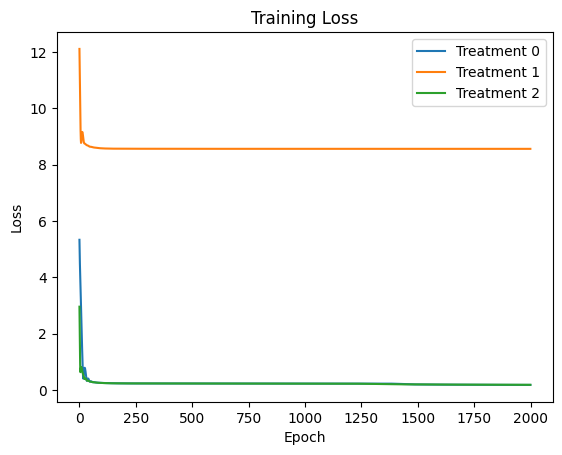

In [101]:
for i in range(3):
    plt.plot(result[i], label=f'Treatment {i}')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

What can we really say about the outcome?

It's random in nature. Remember?

## Repeat

In [102]:
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [104]:
treatments = [torch.nn.init.normal_,
             torch.nn.init.xavier_uniform_,
             torch.nn.init.kaiming_normal_]

Nrepeats = 10 #40
result = {}
for i, treat in enumerate(treatments):

    print('Treatment', i, end=':')
    result[i] = []

    for r in range(Nrepeats):
        print(r, end=' ')
        
        net.init_weights(treat) 
        
        lr = 0.1
        nepochs = 2000
        opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer
        
        # net.train()
        
        losses = []
        for j in range(nepochs):
        
            opt.zero_grad()                    ## <- Clear gradient
            
            # Forward pass
            Yp = net(X)    # or net.predict(X)
            
            # Calculate loss
            # lossf = torch.nn.MSELoss()
            lossf = torch.nn.BCELoss()            
            loss = lossf(Yp, Y)
            
            # Calculate gradient with autograd
            loss.backward()
        
            # Update params
            opt.step()                         ## <- Update one step
                        
            # Track losses
            losses.append(loss.item())        
        # end for j
        result[i].append(losses)
    # end for r
    print()
    ## Caution!!! Here, we experiment for fun, we don't save weights!!!
# end for treat

Treatment 0:0 1 2 3 4 5 6 7 8 9 
Treatment 1:0 1 2 3 4 5 6 7 8 9 
Treatment 2:0 1 2 3 4 5 6 7 8 9 


In [105]:
result.keys()

dict_keys([0, 1, 2])

In [106]:
len(result[0])

10

Text(0, 0.5, 'Loss')

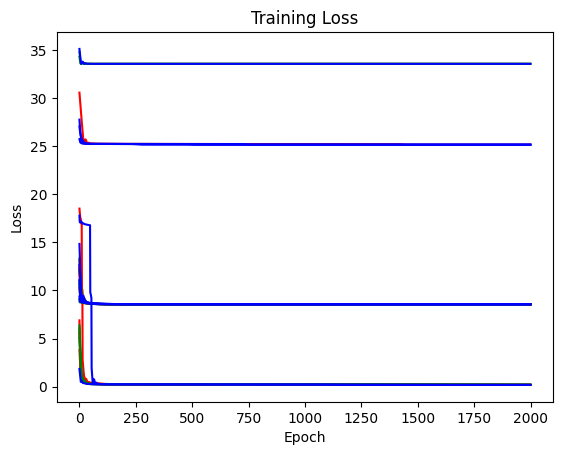

In [108]:
color = ['r', 'g', 'b']

for i in range(3):
    for r in range(Nrepeats):
        plt.plot(result[i][r], color[i])

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.legend()

In [110]:
mati = np.array(result[0])
mati.shape

(10, 2000)

In [115]:
np.min(mati, axis=0)

array([3.82967401, 3.29186821, 2.77556324, ..., 0.18163745, 0.1816272 ,
       0.1816169 ])

Text(0, 0.5, 'Loss')

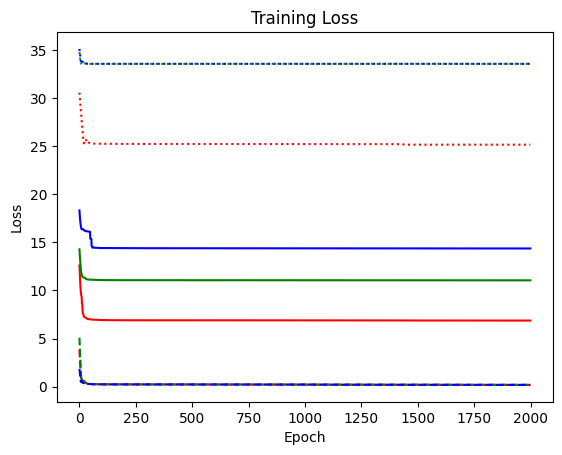

In [117]:
color = ['r', 'g', 'b']

for i in range(3):
    mati = np.array(result[i])
    mini = np.min(mati, axis=0)
    maxi = np.max(mati, axis=0)
    meani = np.mean(mati, axis=0)
    
    plt.plot(mini, color[i], ls='--')
    plt.plot(meani, color[i])
    plt.plot(maxi, color[i], ls=':')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


What can we say now?

# Boxplots

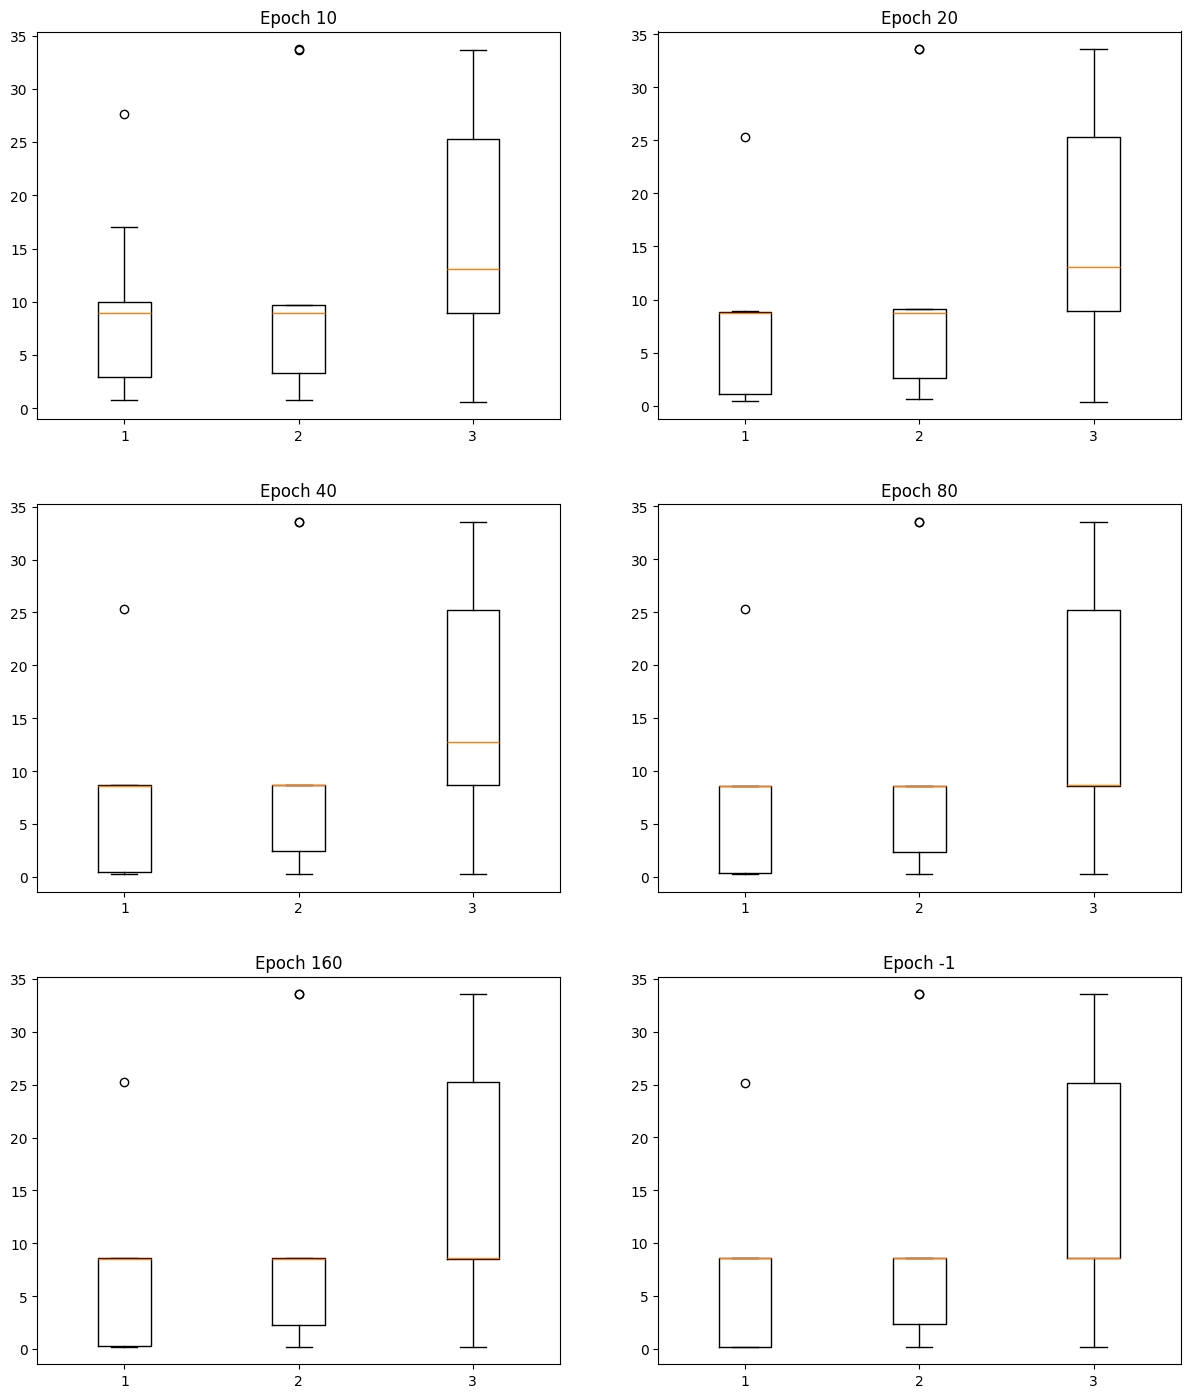

In [125]:
checkpoints = [10, 20, 40, 80, 160, -1]

mat0 = np.array(result[0])
mat1 = np.array(result[1])
mat2 = np.array(result[2])

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.tight_layout(rect=[0.1, 0.1, 2, 3], h_pad=4, w_pad=4)

for j, p in enumerate(checkpoints):
    plt.subplot(3,2,j+1)

    plt.boxplot([mat0[:,p], mat1[:,p], mat2[:,p]])
    plt.title(f'Epoch {p}')

## Significance test

[T Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

> This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

In [141]:
rvs1 = np.random.normal(0, 1, 1000)
rvs2 = np.random.normal(0, 1, 1000)
rvs3 = np.random.normal(2, 1, 1000)
s, p = stats.ttest_ind(rvs1, rvs2)
print(s, p)
s, p = stats.ttest_ind(rvs1, rvs3)
print(s, p)


0.9843554351523699 0.32505996428241046
-44.08349797467952 4.465957961422765e-297


[Rank Sums Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html)

> The Wilcoxon rank-sum test tests the null hypothesis that two sets of measurements are drawn from the same distribution. The alternative hypothesis is that values in one sample are more likely to be larger than the values in the other sample.

In [138]:
import numpy as np
from scipy.stats import ranksums
sample1 = np.random.uniform(-1, 1, 2000)
sample2 = np.random.uniform(-0.5, 1.5, 3000)
sample3 = np.random.uniform(1, 2, 3000)
sample4 = np.random.uniform(1, 2, 300)
s, p = ranksums(sample1, sample2)
print(s, p)
s, p = ranksums(sample1, sample2, alternative='less')
print(s, p)
s, p = ranksums(sample1, sample2, alternative='greater')
print(s, p)
s, p = ranksums(sample1, sample3)
print(s, p)
s, p = ranksums(sample2, sample3)
print(s, p)
s, p = ranksums(sample4, sample3)
print(s, p)


-26.93434669998827 8.701813292028958e-160
-26.93434669998827 4.350906646014479e-160
-26.93434669998827 1.0
-59.99400089985003 0.0
-58.77421878479576 0.0
0.0022244090354298484 0.9982251798373539


[Normality test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)

0.6431202121536437
0.0


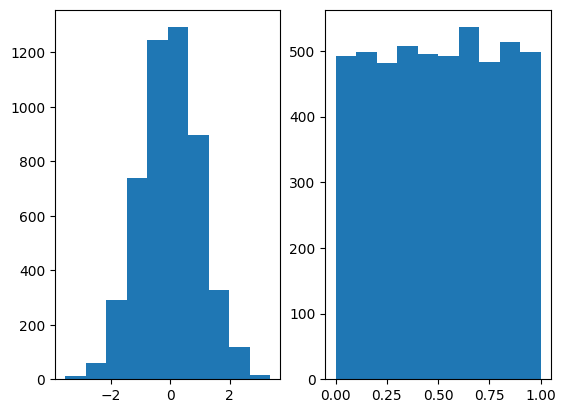

In [133]:
import numpy as np
from scipy import stats
pts = 5000
xn = np.random.normal(0,1,pts)
res = stats.normaltest(xn)
print(res.pvalue)
plt.subplot(1,2,1)
plt.hist(xn);

xu = np.random.uniform(0,1,pts)
res = stats.normaltest(xu)
print(res.pvalue)
plt.subplot(1,2,2)
plt.hist(xu);


## Discussion

* What is the conclusion?

* What are the limitations of this experiment?

* What else would make our learning better (more general, more universal)?

# Multi-class classification

```torch.nn.Softmax``` and ```torch.nn.NLLLoss()(torch.log(yp), y)```

v.s.

```torch.nn.LogSoftmax``` and [```torch.nn.NLLLoss```](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)

v.s.

No softmax with ```torch.nn.CrossEntropyLoss```

## MNIST

In [143]:
!ls

LearnTorch01v1.ipynb		LearnTorch02v1.ipynb	LessonLearned101.ipynb
LearnTorch01v1_toStudent.ipynb	LearnTorch02v1_net.pth


In [15]:
import torchvision
import torchvision.transforms as transforms

# To have data in proper format
transform_f = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True,
                                         download=True, transform=transform_f)

In [16]:
!ls ./data

MNIST


In [17]:
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=50, 
                                          shuffle=True, num_workers=10)  # Per SK

In [237]:
for x, y in trainloader:
    print(x.shape, y.shape)
    break

torch.Size([50, 1, 28, 28]) torch.Size([50])


In [238]:
x.view(-1,1,784).size()

torch.Size([50, 1, 784])

In [239]:
lay = torch.nn.Linear(784, 8)

z = lay(x.view(-1,1,784))
z.size()

torch.Size([50, 1, 8])

In [240]:
x.size()

torch.Size([50, 1, 28, 28])

In [241]:
x[0,0,:].size()

torch.Size([28, 28])

In [242]:
i = 0
xi = x[i,0,:].cpu().detach().numpy()

xi.shape

(28, 28)

In [243]:
y.size()

torch.Size([50])

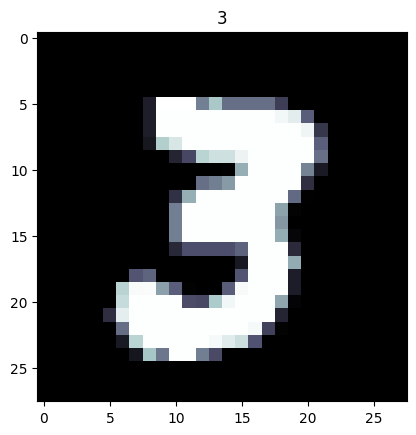

In [244]:
i = 9
xi = x[i,0,:].cpu().detach().numpy()
plt.imshow(xi, cmap=plt.cm.bone)
plt.title('{}'.format(y[i].cpu().detach().numpy()));

## MNIST with ANN

In [245]:
28*28

784

In [249]:
class mlp(torch.nn.Module):                   
    def __init__(self, dev='cpu'):
        super(mlp, self).__init__()           

        self.model = torch.nn.Sequential(            ## <-- Have all the layers in Sequential, in order
            torch.nn.Linear(784, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 10),
            torch.nn.Softmax(dim=-1) 
        ).to(torch.device(dev))                      ## <-- Do it once here!
        
    def predict(self, x):
        '''
        x: (B,1,28,28)
        '''
        y = self.model(x.view(-1,784))                          ## <-- No need to go through each layer, manually
        
        return y

    def forward(self, x):
        return self.predict(x)

In [250]:
net = mlp()

### Softmax with NLLLoss

Not recommend in practice!!!

```NLLLoss```: Negative Log Likelihood Loss


* Multi-class classification

  * Target (ground truth label) $j$ where $j$ is the index of the correct class.
 
    where one and only one position has a value of 1 and that position corresponds to the the class id. The other values are 0's.
 
 
  * Net output before softmax $\mathbf{a} = [a_1, a_2, \ldots, a_K]^T$
 
  * Softmax provides probability-like output,
 
    $$\mathrm{softmax}(\begin{bmatrix}a_1 \\ a_2 \\ \vdots \\ a_K \end{bmatrix}) = \begin{bmatrix} \frac{ \exp(a_1)}{\sum_k \exp(a_k)} \\ \frac{ \exp(a_2)}{\sum_k \exp(a_k)} \\ \vdots \\ \frac{ \exp(a_K)}{\sum_k \exp(a_k)} \end{bmatrix} \equiv \begin{bmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots \\ \hat{y}_K \end{bmatrix}$$
 

    That is,
 
    $\hat{\mathbf{y}} = [\hat{y}_1, \hat{y}_2, \ldots, \hat{y}_K]^T$
 
    where $\hat{y}_i = \frac{ \exp(a_i)}{\sum_k \exp(a_k)}$ for $i = 1, \ldots, K$.
 

  * Cross-entropy loss provides highly penalized loss for wrong class prediction,
 
    $$\mathcal{L}(\hat{\mathbf{y}}, j) = - \log(\hat{y}_j)$$
 

But, wait!

* We did $\exp$ in softmax and then later we do $\log$ in loss calculation?

* Together, we cancel each other out!

\begin{align}
\hat{y}_i &= \frac{ \exp(a_i)}{\sum_k \exp(a_k)} \\
\mathcal{L}(\hat{\mathbf{y}}, j) &= - \log(\hat{y}_j) \\
&= - \log( \frac{ \exp(a_j)}{\sum_k \exp(a_k)} ) \equiv -\log(\mathrm{softmax}(\mathbf{a}))|_{\mbox{Select only component } j}
\end{align}
      
      
      

In addtion, recall that for numerical stability

\begin{align}
\mathrm{softmax}(\mathbf{a}) &= 
\left[ \frac{ \exp(a_i - a_\max)}{\sum_k \exp(a_k - a_\max)} \right]_{i = 1, \ldots, K} \\
\log \mathrm{softmax}(\mathbf{a}) &= 
\left[ \log \left( \frac{ \exp(a_i - a_\max)}{\sum_k \exp(a_k - a_\max)} \right) \right]_{i = 1, \ldots, K} \\
&=
\left[ a_i - a_\max - \underbrace{\log(\sum_k \exp(a_k - a_\max)}_{\mbox{Constant}})\right]_{i = 1, \ldots, K} \\
&= \left[ a_i - a_\max \right]_{i = 1, \ldots, K} - \mbox{Constant}
\end{align}

* It reduces computation!
  * Change expensive division $1/\sum_k \exp(a_k - a_\max)$ for each element to much cheaper subtraction $- \log(\sum_k \exp(a_k - a_\max)$ with only a little extra cost of computing $\log$ once.


In [45]:
ylab

tensor([7, 6, 7, 8, 4, 2, 1, 0, 8, 1, 2, 8, 6, 3, 8, 6, 1, 0, 9, 2, 3, 9, 2, 3,
        7, 5, 2, 5, 9, 2, 1, 0, 2, 5, 4, 7, 6, 5, 8, 1, 0, 1, 2, 0, 1, 0, 1, 0,
        2, 6])

In [67]:
log_softmax = torch.nn.LogSoftmax(dim=1)
loss_fn = torch.nn.NLLLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input.size())
target = torch.tensor([1, 0, 4])
print(target.size())
loss = loss_fn(log_softmax(input), target)

torch.Size([3, 5])
torch.Size([3])


In [70]:
yp[:3,:].size(), ylab[:3].size()

(torch.Size([3, 10]), torch.Size([3]))

In [71]:
lossf(yp[:3,:], ylab[:3])

tensor(-0.1057, grad_fn=<NllLossBackward0>)

In [251]:
net = mlp()
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=1000, 
                                          shuffle=True, num_workers=10)

lr = 0.001
nepochs = 10
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
lossf = torch.nn.NLLLoss(reduction='mean')

stop_flag = False

# net.train()

losses = []
for j in range(nepochs):
    print('Epoch', j)
    for x, ylab in trainloader:

        opt.zero_grad()         
        
        # Forward pass
        yp = net(x)    # or net.predict(X)

        # Calculate loss
        loss = lossf(torch.log(yp), ylab)  ## NLLLoss takes target as label directly,
                                           ## NOT one-hot coding!!!

        if torch.isnan(loss):
            print('Nan break')
            stop_flag = True
            break
            
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step

        # Track losses
        losses.append(loss.item())

    # end for x, y
    if stop_flag:
        break
        
# end for i



Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


Text(0, 0.5, 'Loss')

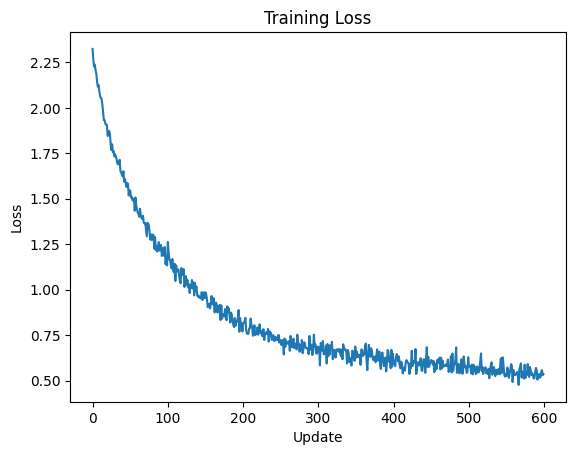

In [252]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Update')
plt.ylabel('Loss')

### Test

In [18]:
# To have data in proper format
transform_f = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))])

mnist_test = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform_f)

testloader = torch.utils.data.DataLoader(mnist_test, batch_size=1000, 
                                          shuffle=True, num_workers=0)

In [254]:
# net.eval()

results = []
for x, ylab in testloader:
    yp = net(x)

    predicted_labels = torch.argmax(yp, dim=1).cpu().detach().numpy()
    
    results.extend(predicted_labels == ylab.cpu().detach().numpy())

print(len(results))
print(np.sum(results))
acc = np.sum(results)/len(results)
print('Accuracy', acc)

10000
8500
Accuracy 0.85


### LogSoftmax with NLLLoss

In [255]:
# N, D
x = torch.tensor([[2, 3, 2],[1, 4, 5]]).float()
lay = torch.nn.LogSoftmax(dim=1)

# torch.sum(torch.exp(lay(x)), dim=1)
torch.exp(lay(x))

tensor([[0.2119, 0.5761, 0.2119],
        [0.0132, 0.2654, 0.7214]])

In [256]:
class mlp(torch.nn.Module):                   
    def __init__(self, dev='cpu'):
        super(mlp, self).__init__()           

        self.model = torch.nn.Sequential(           
            torch.nn.Linear(784, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 10),
            torch.nn.LogSoftmax(dim=1)            ## <-- better off with LogSoftmax
        ).to(torch.device(dev))                     
        
    def predict(self, x):
        '''
        x: (B,1,28,28)
        '''
        y = self.model(x.view(-1,784))                         
        
        return y

    def forward(self, x):
        return self.predict(x)

In [257]:
net = mlp()
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=1000, 
                                          shuffle=True, num_workers=10)

lr = 0.001
nepochs = 10
opt = torch.optim.Adam(net.parameters(), lr)  ## <- Set up optimizer

# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
lossf = torch.nn.NLLLoss(reduction='mean')

stop_flag = False

# net.train()

losses = []
for j in range(nepochs):
    print('Epoch', j)
    for x, ylab in trainloader:

        opt.zero_grad()         
        
        # Forward pass
        yp = net(x)    # or net.predict(X)

        # Calculate loss
        loss = lossf(yp, ylab)  ## <-- We don't need log here anymore

        if torch.isnan(loss):
            print('Nan break')
            stop_flag = True
            break
            
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step

        # Track losses
        losses.append(loss.item())

    # end for x, y
    if stop_flag:
        break
        
# end for i



Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


Text(0, 0.5, 'Loss')

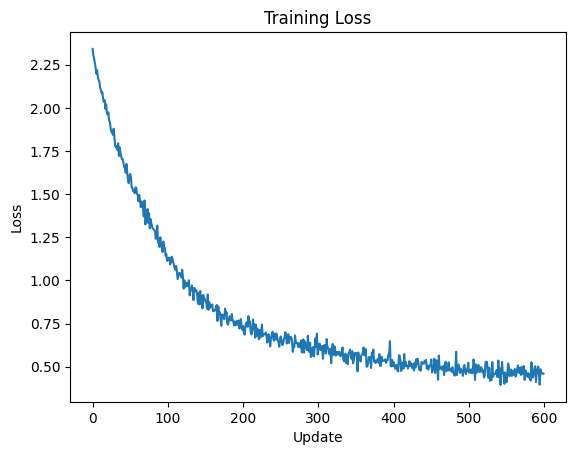

In [258]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Update')
plt.ylabel('Loss')

In [259]:
# net.eval()

results = []
for x, ylab in testloader:
    yp = net(x)

    predicted_labels = torch.argmax(yp, dim=1).cpu().detach().numpy()
    
    results.extend(predicted_labels == ylab.cpu().detach().numpy())

print(len(results))
print(np.sum(results))
acc = np.sum(results)/len(results)
print('Accuracy', acc)

10000
8724
Accuracy 0.8724


### No softmax (identity output activation) and CrossEntropyLoss

In [25]:
class mlp(torch.nn.Module):                   
    def __init__(self, dev='cpu'):
        super(mlp, self).__init__()           

        self.model = torch.nn.Sequential(           
            torch.nn.Linear(784, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 10),
                                      ## <-- best off with nothing!
        ).to(torch.device(dev))                     
        
    def predict(self, x):
        '''
        x: (B,1,28,28)
        '''
        y = self.model(x.view(-1,784))                         
        
        return y

    def forward(self, x):
        return self.predict(x)

In [26]:
net = mlp()
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=1000, 
                                          shuffle=True, num_workers=10)

lr = 0.001
nepochs = 10
opt = torch.optim.Adam(net.parameters(), lr)  

lossf = torch.nn.CrossEntropyLoss()            ## <-- CrossEntropyLoss

stop_flag = False

# net.train()

losses = []
for j in range(nepochs):
    print('Epoch', j)
    for x, ylab in trainloader:

        opt.zero_grad()         
        
        # Forward pass
        yp = net(x)    # or net.predict(X)

        # Calculate loss
        loss = lossf(yp, ylab)  ## <-- We don't need log here anymore

        if torch.isnan(loss):
            print('Nan break')
            stop_flag = True
            break
            
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step

        # Track losses
        losses.append(loss.item())

    # end for x, y
    if stop_flag:
        break
        
# end for i



Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


Text(0, 0.5, 'Loss')

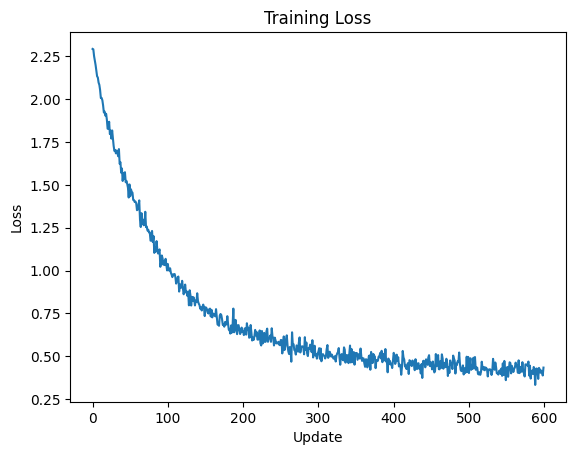

In [28]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Update')
plt.ylabel('Loss')

In [29]:
# net.eval()

results = []
for x, ylab in testloader:
    yp = net(x)

    predicted_labels = torch.argmax(yp, dim=1).cpu().detach().numpy()
    
    results.extend(predicted_labels == ylab.cpu().detach().numpy())

print(len(results))
print(np.sum(results))
acc = np.sum(results)/len(results)
print('Accuracy', acc)

10000
8867
Accuracy 0.8867


[```torch.nn.NLLLoss```](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)

* Use ```LogSoftmax``` with ```NLLLoss```
* Or, No softmax at all with ```CrossEntropyLoss```

## MNIST with Conv layers

[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

Arguments: in_channels, out_channels, kernel_size, stride=1, padding=0, ...

In [121]:
for x, ylab in testloader:
    break

x.size()

torch.Size([1000, 1, 28, 28])

In [123]:
lay = torch.nn.Conv2d(1, 8, 3)
output = lay(x)
output.size()

torch.Size([1000, 8, 26, 26])

In [124]:
lay = torch.nn.Conv2d(1, 8, 3, stride=2)
output = lay(x)
output.size()

torch.Size([1000, 8, 13, 13])

In [140]:
lay1 = torch.nn.Conv2d(1, 8, 3)
lay2 = torch.nn.Conv2d(8, 8, 5, stride=2)
lay3 = torch.nn.Conv2d(8, 4, 5, stride=2)

x1 = lay1(x)
x2 = lay2(x1)
x3 = lay3(x2)
print(x3.size())

lay4 = torch.nn.Flatten(start_dim=1, end_dim=-1)
x4 = lay4(x3)
print(x4.size())

torch.Size([1000, 4, 3, 3])
torch.Size([1000, 36])


In [173]:
        lay = torch.nn.Sequential(  
            
            torch.nn.Conv2d(1, 8, 5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 4, 5, stride=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(4, 3, 5, stride=2),
            torch.nn.ReLU(),
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            torch.nn.Linear(12, 10)                
        )

        xo = lay(x)
        x.size(), xo.size()

(torch.Size([1000, 1, 28, 28]), torch.Size([1000, 10]))

In [162]:
# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters
print(f'The model has {count_parameters(lay):,} trainable parameters')


The model has 1,445 trainable parameters


C.f.

Weights: ```784*8 + 8*10``` in Two-layer MLP using 8 HUs.

In [167]:
784*8 + 8*10

6352

In [164]:
for p in lay.parameters():
    break

In [166]:
print(p.numel.__doc__)


numel() -> int

See :func:`torch.numel`



https://pytorch.org/docs/stable/generated/torch.numel.html

In [30]:
class mlp(torch.nn.Module):                   
    def __init__(self):
        super(mlp, self).__init__()           

        self.model = torch.nn.Sequential(              
            torch.nn.Conv2d(1, 8, 5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 4, 5, stride=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(4, 3, 5, stride=2),
            torch.nn.ReLU(),
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            torch.nn.Linear(12, 10)                
        )
        
    def predict(self, x):
        '''
        x: (B,1,28,28)
        '''
        y = self.model(x)            ## <-- x needs to have a proper structure.
        
        return y

    def forward(self, x):
        return self.predict(x)

In [31]:
net = mlp()
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=1000, 
                                          shuffle=True, num_workers=10)

lr = 0.001
nepochs = 10
opt = torch.optim.Adam(net.parameters(), lr)  

lossf = torch.nn.CrossEntropyLoss()            

stop_flag = False

# net.train()

losses = []
for j in range(nepochs):
    print('Epoch', j)
    for x, ylab in trainloader:

        opt.zero_grad()         
        
        # Forward pass
        yp = net(x)    # or net.predict(X)

        # Calculate loss
        loss = lossf(yp, ylab)  ## <-- We don't need log here anymore

        if torch.isnan(loss):
            print('Nan break')
            stop_flag = True
            break
            
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step

        # Track losses
        losses.append(loss.item())

    # end for x, y
    if stop_flag:
        break
        
# end for i

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


Text(0, 0.5, 'Loss')

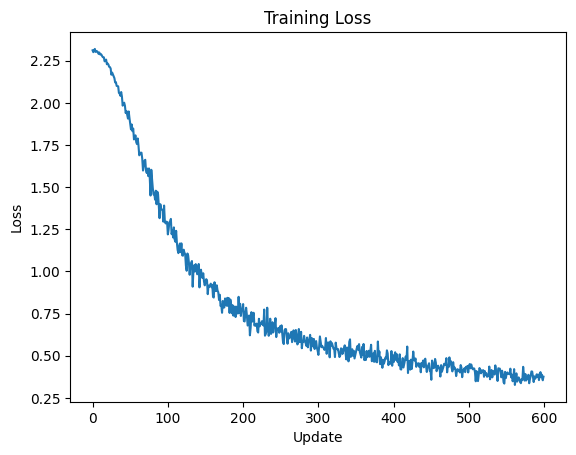

In [32]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Update')
plt.ylabel('Loss')

In [33]:
# net.eval()

results = []
for x, ylab in testloader:
    yp = net(x)

    predicted_labels = torch.argmax(yp, dim=1).cpu().detach().numpy()
    
    results.extend(predicted_labels == ylab.cpu().detach().numpy())

print(len(results))
print(np.sum(results))
acc = np.sum(results)/len(results)
print('Accuracy', acc)

10000
9007
Accuracy 0.9007


# Pooling layers

Check out https://pytorch.org/docs/stable/nn.html#pooling-layers

* ```MaxPool2d```
* ```AvgPool2d```
* ```LPPool2d```

In [178]:
# pool of square window of size=3, stride=2
lay = torch.nn.MaxPool2d(3, stride=2)
x = torch.randn(20, 16, 50, 32)
output = lay(x)
output.size()

torch.Size([20, 16, 24, 15])

In [180]:
lay1 = torch.nn.Sequential(              
            torch.nn.Conv2d(1, 8, 5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 4, 5, stride=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(4, 3, 5, stride=2),
            torch.nn.ReLU(),
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            torch.nn.Linear(12, 10)                
        )

count_parameters(lay1),

1445

In [182]:
lay2 = torch.nn.Sequential(              
            torch.nn.Conv2d(1, 8, 5),
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(5, stride=3),
    
            torch.nn.Conv2d(8, 3, 5, stride=2),
            torch.nn.ReLU(),
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            torch.nn.Linear(12, 10)                
        )

count_parameters(lay2)

941

In [34]:
class mlp(torch.nn.Module):                   
    def __init__(self):
        super(mlp, self).__init__()           

        self.model = torch.nn.Sequential(              
            torch.nn.Conv2d(1, 8, 5),
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(5, stride=3),
    
            torch.nn.Conv2d(8, 3, 5, stride=2),
            torch.nn.ReLU(),
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            torch.nn.Linear(12, 10)                
        )
        
    def predict(self, x):
        '''
        x: (B,1,28,28)
        '''
        y = self.model(x)            ## <-- x needs to have a proper structure.
        
        return y

    def forward(self, x):
        return self.predict(x)

In [35]:
net = mlp()
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=1000, 
                                          shuffle=True, num_workers=10)

lr = 0.001
nepochs = 10
opt = torch.optim.Adam(net.parameters(), lr)  

lossf = torch.nn.CrossEntropyLoss()            

stop_flag = False

# net.train()

losses = []
for j in range(nepochs):
    print('Epoch', j)
    for x, ylab in trainloader:

        opt.zero_grad()         
        
        # Forward pass
        yp = net(x)    # or net.predict(X)

        # Calculate loss
        loss = lossf(yp, ylab)  ## <-- We don't need log here anymore

        if torch.isnan(loss):
            print('Nan break')
            stop_flag = True
            break
            
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step

        # Track losses
        losses.append(loss.item())

    # end for x, y
    if stop_flag:
        break
        
# end for i

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


Text(0, 0.5, 'Loss')

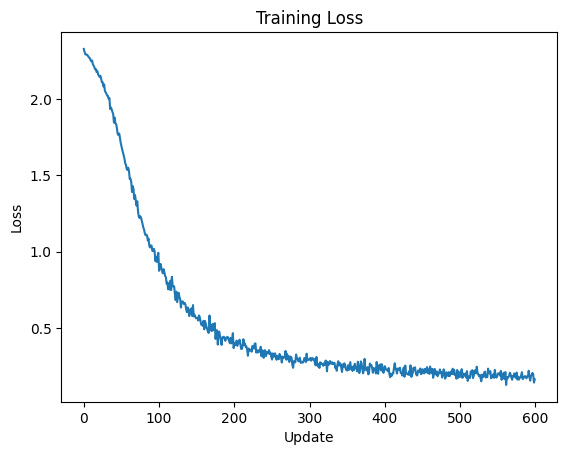

In [36]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Update')
plt.ylabel('Loss')

In [37]:
# net.eval()

results = []
for x, ylab in testloader:
    yp = net(x)

    predicted_labels = torch.argmax(yp, dim=1).cpu().detach().numpy()
    
    results.extend(predicted_labels == ylab.cpu().detach().numpy())

print(len(results))
print(np.sum(results))
acc = np.sum(results)/len(results)
print('Accuracy', acc)

10000
9519
Accuracy 0.9519


# Misc: Dropout, BatchNorm, LayerNorm

## Dropout

* Play a role of regularization

* Break co-adaptation

* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

  > During training, randomly zeroes some of the elements of the input tensor with probability $p$.

* ```net.train()``` vs ```net.eval()```
  
  * ```net.training```
 
* Training mode (indicated by ```net.training``` is ```True```; set by ```net.train()```)

  * Do drop out and scaling what remains with $1/(1-p)$ to compensate dropped magnitude.
 
* Evaluation mode (indicated by ```net.training``` is ```False```; set by ```net.eval()```)

  * Do nothing: no drop out; no scaling. Whatever gets in gets out.

In [21]:
pdrop = 0.75

x = torch.randn(2,3,3)
print('x=', x, '\n')

print('x/(1-p)=\n', x/(1-pdrop), '\n')

lay = torch.nn.Dropout(p=pdrop)
print(f'{lay.training=}\n')
x1 = lay(x)
print('x1=\n', x1, '\n')

x= tensor([[[ 0.5623, -0.3645,  2.2319],
         [-0.0781, -0.9185,  0.2086],
         [-0.2798,  0.4951,  1.3695]],

        [[-0.1068, -0.2979,  0.3854],
         [ 0.1259, -0.6513, -0.4478],
         [-0.1309,  0.5534, -1.0991]]]) 

x/(1-p)=
 tensor([[[ 2.2493, -1.4582,  8.9277],
         [-0.3125, -3.6739,  0.8346],
         [-1.1190,  1.9803,  5.4779]],

        [[-0.4271, -1.1916,  1.5415],
         [ 0.5037, -2.6053, -1.7914],
         [-0.5236,  2.2136, -4.3964]]]) 

lay.training=True

x1=
 tensor([[[ 0.0000, -0.0000,  0.0000],
         [-0.0000, -0.0000,  0.0000],
         [-0.0000,  0.0000,  0.0000]],

        [[-0.4271, -0.0000,  1.5415],
         [ 0.0000, -0.0000, -0.0000],
         [-0.5236,  0.0000, -0.0000]]]) 



In [19]:
print(f'{lay.training=}\n')
lay.eval()
print(f'{lay.training=}\n')
lay.train()
print(f'{lay.training=}\n')


lay.training=True

lay.training=False

lay.training=True



In [20]:
print('x=', x, '\n')

print('x/(1-p)=\n', x/(1-pdrop), '\n')

lay = torch.nn.Dropout(p=pdrop)

lay.eval()
print(f'{lay.training=}\n')

x1 = lay(x)
print('x1=\n', x1, '\n')

lay.train()
print(f'{lay.training=}\n')

x2= lay(x)
print('x2=\n', x2, '\n')


x= tensor([[[-0.9580,  0.5782,  1.6447],
         [-0.0750, -0.7463,  0.0180],
         [-1.1831, -1.7258, -0.0138]],

        [[ 0.0193,  0.1420,  0.1514],
         [ 0.1134, -0.0278, -1.6882],
         [-1.4091, -1.7647, -0.0199]]]) 

x/(1-p)=
 tensor([[[-3.8319,  2.3126,  6.5787],
         [-0.2999, -2.9852,  0.0719],
         [-4.7325, -6.9031, -0.0550]],

        [[ 0.0772,  0.5682,  0.6057],
         [ 0.4536, -0.1111, -6.7527],
         [-5.6365, -7.0587, -0.0797]]]) 

lay.training=False

x1=
 tensor([[[-0.9580,  0.5782,  1.6447],
         [-0.0750, -0.7463,  0.0180],
         [-1.1831, -1.7258, -0.0138]],

        [[ 0.0193,  0.1420,  0.1514],
         [ 0.1134, -0.0278, -1.6882],
         [-1.4091, -1.7647, -0.0199]]]) 

lay.training=True

x2=
 tensor([[[-0.0000,  0.0000,  6.5787],
         [-0.0000, -0.0000,  0.0000],
         [-0.0000, -6.9031, -0.0000]],

        [[ 0.0000,  0.0000,  0.6057],
         [ 0.4536, -0.0000, -6.7527],
         [-0.0000, -0.0000, -0.0000]]]) 



In [19]:
class mlp(torch.nn.Module):                   
    def __init__(self):
        super(mlp, self).__init__()           

        self.model = torch.nn.Sequential(              
            torch.nn.Conv2d(1, 8, 5),    
            torch.nn.Dropout(p=0.2),      # I added dropout here with p=0.2
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(5, stride=3),
    
            torch.nn.Conv2d(8, 3, 5, stride=2),
            torch.nn.ReLU(),
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            torch.nn.Linear(12, 10)                
        )
        
    def predict(self, x):
        '''
        x: (B,1,28,28)
        '''
        y = self.model(x)            ## <-- x needs to have a proper structure.
        
        return y

    def forward(self, x):
        return self.predict(x)

In [20]:
net = mlp()
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=1000, 
                                          shuffle=True, num_workers=10)

lr = 0.001
nepochs = 10
opt = torch.optim.Adam(net.parameters(), lr)  

lossf = torch.nn.CrossEntropyLoss()            

stop_flag = False

net.train()    ## <-- With dropout in the model, this must be ensured.

losses = []
for j in range(nepochs):
    print('Epoch', j)
    for x, ylab in trainloader:

        opt.zero_grad()         
        
        # Forward pass
        yp = net(x)    # or net.predict(X)

        # Calculate loss
        loss = lossf(yp, ylab)  ## <-- We don't need log here anymore

        if torch.isnan(loss):
            print('Nan break')
            stop_flag = True
            break
            
        # Calculate gradient with autograd
        loss.backward()
    
        # Update params
        opt.step()                         ## <- Update one step

        # Track losses
        losses.append(loss.item())

    # end for x, y
    if stop_flag:
        break
        
# end for i

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


Text(0, 0.5, 'Loss')

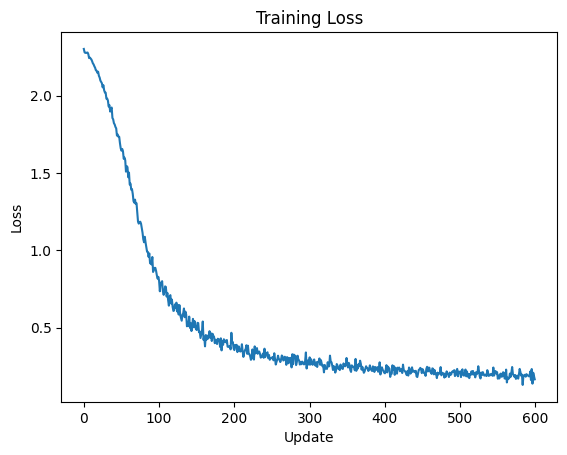

In [21]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Update')
plt.ylabel('Loss')

In [22]:
net.eval()                    ## Now it's a must!!!

results = []
for x, ylab in testloader:
    yp = net(x)

    predicted_labels = torch.argmax(yp, dim=1).cpu().detach().numpy()
    
    results.extend(predicted_labels == ylab.cpu().detach().numpy())

print(len(results))
print(np.sum(results))
acc = np.sum(results)/len(results)
print('Accuracy', acc)

10000
9503
Accuracy 0.9503


### With Dropout, don't forget train()/eval() mode!!!

In [23]:
net.train()
net.training

True

In [24]:
# net.eval()                    ## Now it's a must!!!

results = []
for x, ylab in testloader:
    yp = net(x)

    predicted_labels = torch.argmax(yp, dim=1).cpu().detach().numpy()
    
    results.extend(predicted_labels == ylab.cpu().detach().numpy())

print(len(results))
print(np.sum(results))
acc = np.sum(results)/len(results)
print('Accuracy', acc)

10000
9477
Accuracy 0.9477


Not a bad result!!! But, it's not a right way to do it.
BTW, it's fluke. We won't be always this lucky.

# End LearnTorch02v2_toStudent

# Play

* https://pytorch.org/audio/stable/tutorials/audio_io_tutorial.html

* https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html

* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

* https://pytorch.org/tutorials/beginner/fgsm_tutorial.html


* https://pytorch.org/tutorials/beginner/profiler.html